# Load packages

In [113]:
import pandas as pd
import re # regexes
from pathlib import Path # better way to work with filepaths
from matplotlib import pyplot as plt
import geopandas as gpd # for maps
from shapely.geometry import Point, Polygon
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines

# Load in Data

In [114]:
# List all .txt files in data directory
# One file for each year of baby names in the US since late 1800s until 2018
baby_name_folder = Path.cwd() / "data" / "names"
baby_name_files = [x for x in baby_name_folder.glob('*txt')]
# Have a look at one file
baby_name_files[0]

PosixPath('/Users/jas/github/udacity-data-scientist-nanodegree-project-1-write-a-data-science-blog-post/data/names/yob2000.txt')

In [115]:
def parse_raw_data(f):
    df = pd.read_csv(f, header = 0, names=['name','sex','babies'])
    # Add year from the filename
    # Data itself doesn't have the year, but the filename always has the pattern of yob{4-digit-Year}.txt
    df["year"] = int(re.search(r'\d\d\d\d', str(f), re.IGNORECASE).group(0))
    return(df)

# Map function to each file
baby_names_list = map(parse_raw_data, baby_name_files)
# Load all data into a single pandas dataframe
baby_names = pd.concat(baby_names_list)
baby_names.head()

,name,sex,babies,year
0,Hannah,F,23082,2000
1,Madison,F,19968,2000
2,Ashley,F,17997,2000
3,Sarah,F,17702,2000
4,Alexis,F,17629,2000


### Data broken down by states

In [116]:
!ls data # list all files and folders in data folder

names          namesbystate   states_21basic


In [117]:
!ls data/namesbystate # one file per state, all CAPS for .TXT

AK.TXT          HI.TXT          MI.TXT          NV.TXT          TX.TXT
AL.TXT          IA.TXT          MN.TXT          NY.TXT          UT.TXT
AR.TXT          ID.TXT          MO.TXT          OH.TXT          VA.TXT
AZ.TXT          IL.TXT          MS.TXT          OK.TXT          VT.TXT
CA.TXT          IN.TXT          MT.TXT          OR.TXT          WA.TXT
CO.TXT          KS.TXT          NC.TXT          PA.TXT          WI.TXT
CT.TXT          KY.TXT          ND.TXT          RI.TXT          WV.TXT
DC.TXT          LA.TXT          NE.TXT          SC.TXT          WY.TXT
DE.TXT          MA.TXT          NH.TXT          SD.TXT
FL.TXT          MD.TXT          NJ.TXT          StateReadMe.pdf
GA.TXT          ME.TXT          NM.TXT          TN.TXT


In [118]:
!head data/namesbystate/AK.TXT # Take a peak at a file

AK,F,1910,Mary,14
AK,F,1910,Annie,12
AK,F,1910,Anna,10
AK,F,1910,Margaret,8
AK,F,1910,Helen,7
AK,F,1910,Elsie,6
AK,F,1910,Lucy,6
AK,F,1910,Dorothy,5
AK,F,1911,Mary,12
AK,F,1911,Margaret,7


In [119]:
baby_namesbystate_folder = Path.cwd() / "data" / "namesbystate"
baby_namesbystate_files = [x for x in baby_namesbystate_folder.glob('*TXT')]
# Have a look at one file
baby_namesbystate_files[0]

PosixPath('/Users/jas/github/udacity-data-scientist-nanodegree-project-1-write-a-data-science-blog-post/data/namesbystate/IN.TXT')

In [120]:
# Map function to each file
baby_namesbystate_list = map(lambda f: pd.read_csv(f, header = 0,\
names=['state','sex','year','name','babies']), baby_namesbystate_files)

# Load all data into a single pandas dataframe
baby_namesbystate = pd.concat(baby_namesbystate_list)
# Get first letter of name
baby_namesbystate['first_letter'] = baby_namesbystate['name'].str[0]
baby_namesbystate.head()

,state,sex,year,name,babies,first_letter
0,IN,F,1910,Helen,324,H
1,IN,F,1910,Ruth,238,R
2,IN,F,1910,Dorothy,215,D
3,IN,F,1910,Mildred,200,M
4,IN,F,1910,Margaret,196,M


# Exploratory data analysis 

### How many years of data do we have?

In [121]:
baby_names["year"].describe()

count    1.956907e+06
mean     1.975565e+03
std      3.419002e+01
min      1.880000e+03
25%      1.952000e+03
50%      1.985000e+03
75%      2.004000e+03
max      2.018000e+03
Name: year, dtype: float64

In [122]:
# Avoid scientific notation
# https://stackoverflow.com/questions/40347689/dataframe-describe-suppress-scientific-notation
baby_names["year"].describe().apply(lambda x: format(x, 'f'))

count    1956907.000000
mean        1975.564815
std           34.190022
min         1880.000000
25%         1952.000000
50%         1985.000000
75%         2004.000000
max         2018.000000
Name: year, dtype: object

In [123]:
baby_names['year'].nunique()

139

* 1880 to 2018, 139 years of data

### How has the US born population increased over the years - using baby names as a proxy?

In [124]:
baby_names.groupby('year')['babies'].sum()

year
1880     194419
1881     185777
1882     213385
1883     208932
1884     234244
         ...   
2014    3677978
2015    3671535
2016    3638301
2017    3542175
2018    3468665
Name: babies, Length: 139, dtype: int64

* We can see the huge growth over the decades. Remember, this is NOT the total US Population. In fact, it is the top 1000 names which represent > 70% of US baby names in the US for 2018 (latest year of data)

### Has the diversity (uniqueness) of baby names increased over the years?

In [125]:
baby_names.groupby('year')['name'].nunique()

year
1880     1889
1881     1830
1882     2012
1883     1962
1884     2158
        ...  
2014    30742
2015    30603
2016    30415
2017    30006
2018    29494
Name: name, Length: 139, dtype: int64

* Appears to be the case

### What first letter is the most popular in the US in the past few years?

In [126]:
baby_names['first_letter'] = baby_names['name'].str[0]
first_letters = baby_names.groupby(['year','first_letter']).agg({'babies':'sum'}).reset_index()
first_letters.head()


,year,first_letter,babies
0,1880,A,16740
1,1880,B,5991
2,1880,C,15817
3,1880,D,4706
4,1880,E,18338


In [127]:
# get dataframe sorted by baby names in each year
g = first_letters.groupby(["year"]).apply(lambda x: x.sort_values(["babies"], ascending = False)).reset_index(drop=True)
# select top N rows within each year
g.groupby('year').head(5)[g['year']>=2008]

,year,first_letter,babies
3303,2008,A,548561
3304,2008,J,466692
3305,2008,M,332027
3306,2008,C,288109
3307,2008,K,250422
3329,2009,A,533016
3330,2009,J,441518
3331,2009,M,317774
3332,2009,C,281708
3333,2009,K,240587


* Looks like A, J, and M have been consistently popular for the past decade

 https://www.washingtonpost.com/technology/2020/05/08/musk-grimes-baby-name/

### Elon Musk's baby name

* If you haven't heard, Elon and his girlfriend (singer Grimes) recently had a baby boy and they gave him a unique name:
X Æ A-12. However, the state of California only allows 26 english letters on the birth certificate. So I suspect
they may eventually have to give baby X a more traditional name. What would be some good options?

### X marks the spot

* X seems to be the first choice, going by Grandma's latest tweet - https://twitter.com/mayemusk/status/1259297517776171008


### So what were the most popular US baby names starting with X in the past decade?

In [128]:
elon_baby_X_RAW = baby_names[(baby_names['year']>=2008) & (baby_names['first_letter']=='X') & (baby_names['sex']=='M')]
#elon_baby_X_RAW.groupby('name')['babies'].sum().sort_values(ascending = False).head(10)
elon_baby_X = elon_baby_X_RAW.groupby('name')['babies'].sum().sort_values(ascending = False).reset_index()
#chance of being named if first letter chosen is X based on this frequency count
elon_baby_X['percent_total'] = round(100 * (elon_baby_X['babies']/elon_baby_X['babies'].sum()), 2)
top_10_X = elon_baby_X.head(10)
top_10_X

,name,babies,percent_total
0,Xavier,56833,61.29
1,Xander,19657,21.20
2,Xzavier,4058,4.38
3,Xavi,1747,1.88
4,Xavion,992,1.07
5,Xaiden,763,0.82
6,Xavian,756,0.82
7,Xavior,646,0.70
8,Xayden,513,0.55
9,Xzavion,508,0.55


### A - Ash or Archangel or A...?


* Another strong possibility is a name would starts with A Could it be Ash or Archangel? What variants could we expect?
* **A** has been the most popular first letter for the past decade

In [129]:
elon_baby_A_RAW = baby_names[(baby_names['year']>=2008) & (baby_names['first_letter']=='A') & (baby_names['sex']=='M')]
#elon_baby_X_RAW.groupby('name')['babies'].sum().sort_values(ascending = False).head(10)
elon_baby_A = elon_baby_A_RAW.groupby('name')['babies'].sum().sort_values(ascending = False).reset_index()
#chance of being named if first letter chosen is A based on this frequency count
#elon_baby_A['percent_total'] = 100 * (elon_baby_A['babies']/elon_baby_A['babies'].sum())
elon_baby_A['percent_total'] = round(100 * elon_baby_A['babies']/elon_baby_A['babies'].sum(), 2)
top_10_A = elon_baby_A.head(10)
top_10_A

,name,babies,percent_total
0,Alexander,167408,7.72
1,Aiden,151534,6.99
2,Anthony,138848,6.40
3,Andrew,129570,5.98
4,Aaron,81285,3.75
5,Angel,78119,3.60
6,Adrian,75646,3.49
7,Austin,69839,3.22
8,Adam,58142,2.68
9,Ayden,56200,2.59


* Angel is in the top 10, my bet is that could be the nickname for the official name of Archangel. This time the distribution is much more evenly distribute so no clear winner here. 

In [130]:
plt.rcParams["figure.figsize"] = (12, 6)

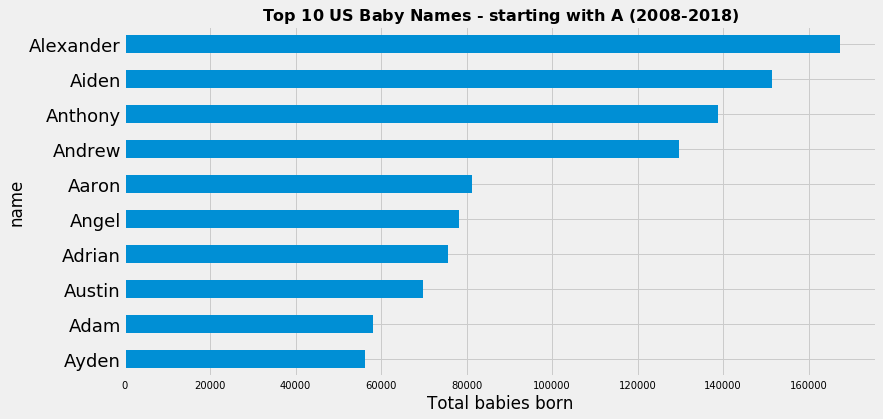

In [131]:
#https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barh.html

ax = top_10_A.plot.barh(x='name', y='babies')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Total babies born')
ax.set_title('Top 10 US Baby Names - starting with '  + r"$\bf{" + " A " + "}$" + ' (2008-2018)', fontdict={'size':16, 'weight':600})
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=18)
ax.get_legend().remove()
#ax.axes.get_yaxis().set_visible(False)
plt.savefig(Path.cwd() / "figs" / "plot2.png", dpi=200)
#plt.show()

### Back to X names

In [132]:
plt.rcParams["figure.figsize"] = (12, 6)

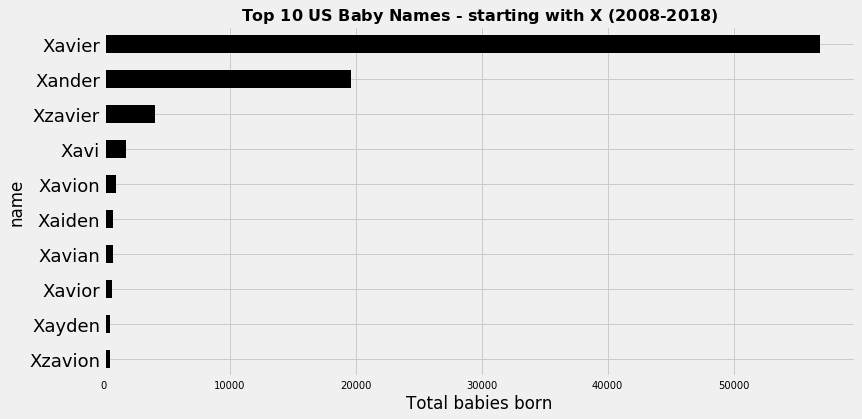

In [133]:
ax = top_10_X.plot.barh(x='name', y='babies', color='black')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Total babies born')
ax.set_title('Top 10 US Baby Names - starting with '  + r"$\bf{" + " X " + "}$" + ' (2008-2018)', fontdict={'size':16, 'weight':600})
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=18)
ax.get_legend().remove()
plt.savefig(Path.cwd() / "figs" / "plot1.png", dpi=200)
##plt.show()

https://www.khou.com/article/news/local/houston-mayor-turner-letter-to-elon-musk-tesla/285-7263ab97-5153-4492-bbaf-4ea4091ec08c

### What if the Musks move to Nevada or Texas?

* It sounds like they want a unique name. 
* So what are the rarest names starting with A or X.(keeping in mind we have data on the top 1000 names which represent 70 % of all names)
* Not restrict it to the most recent data, but all 100+ years of baby names 

* Texas will be different colour

In [134]:
elon_babybystate_RAW = baby_namesbystate[(baby_namesbystate['first_letter'].isin(['A','X']))\
& (baby_namesbystate['year']>=1880)\
& (baby_namesbystate['sex']=='M') & (baby_namesbystate['state'].isin(['TX','NV']))]
elon_babybystate_RAW.head()

,state,sex,year,name,babies,first_letter
25197,NV,M,1912,Alfred,5,A
25198,NV,M,1912,Arthur,5,A
25232,NV,M,1914,Arthur,5,A
25244,NV,M,1915,Albert,11,A
25271,NV,M,1916,Arthur,8,A


In [135]:
elon_babybystate = elon_babybystate_RAW.groupby(['state','name', 'first_letter'])['babies'].sum().reset_index().sort_values(['state', 'babies'], ascending=[True, True])
elon_babybystate.head(5)

,state,name,first_letter,babies
2,NV,Abdiel,A,5
10,NV,Addison,A,5
15,NV,Adriano,A,5
27,NV,Alden,A,5
49,NV,Amani,A,5


In [136]:
# I still think there would be some controversy with any of these names

#### Rarest baby names starting with **A** and **X**

In [137]:

elon_plot_TX_NV_data_rarest = elon_babybystate.groupby(['state','first_letter'])['babies'].nsmallest(5).reset_index().set_index('level_2').join(elon_babybystate['name'])
elon_plot_TX_NV_data_rarest 


,state,first_letter,babies,name
level_2,,,,
2,NV,A,5,Abdiel
10,NV,A,5,Addison
15,NV,A,5,Adriano
27,NV,A,5,Alden
49,NV,A,5,Amani
107,NV,X,11,Xavi
109,NV,X,54,Xzavier
106,NV,X,314,Xander
108,NV,X,1183,Xavier


### Does NV only have 4 **X** names?

In [138]:
elon_babybystate[(elon_babybystate['first_letter'] == 'X') & (elon_babybystate['state'] == 'NV')]

,state,name,first_letter,babies
107,NV,Xavi,X,11
109,NV,Xzavier,X,54
106,NV,Xander,X,314
108,NV,Xavier,X,1183


### Most popular names starting with **A** or **X**

In [139]:

elon_plot_TX_NV_data = elon_babybystate.groupby(['state','first_letter'])['babies'].nlargest(5).reset_index().set_index('level_2').join(elon_babybystate['name'])
elon_plot_TX_NV_data

,state,first_letter,babies,name
level_2,,,,
63,NV,A,8009,Anthony
59,NV,A,5176,Andrew
33,NV,A,4660,Alexander
1,NV,A,3422,Aaron
61,NV,A,3032,Angel
108,NV,X,1183,Xavier
106,NV,X,314,Xander
109,NV,X,54,Xzavier
107,NV,X,11,Xavi


### Basic Plot

In [140]:
### Maps of TX and NV

In [141]:
usa = gpd.read_file(Path.cwd() / "data" / "states_21basic" / "states.shp")
usa.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."


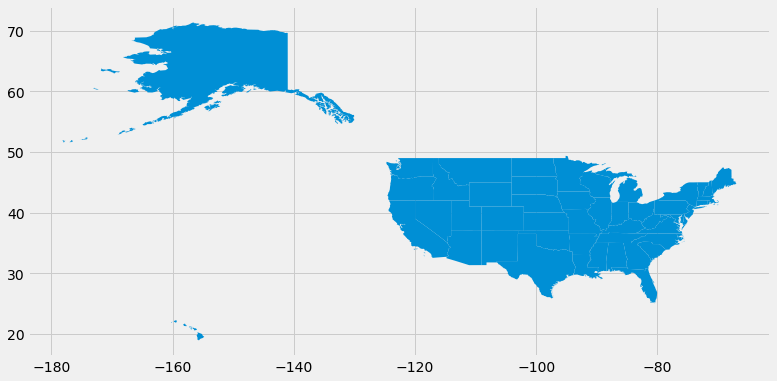

In [142]:
usa.plot()

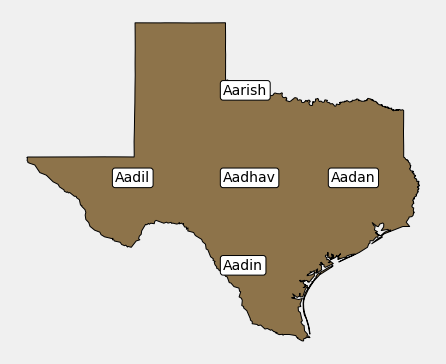

In [143]:
ax = usa[usa.STATE_ABBR == 'TX'].geometry.boundary.plot(fc='#8D734A', color='black',edgecolor='grey',linewidth = 1)

bbox_props = dict(boxstyle="round,pad=0.2", fc="w", ec="k", lw=1)

TX_A_names = elon_plot_TX_NV_data_rarest[(elon_plot_TX_NV_data_rarest['state'] == 'TX') & (elon_plot_TX_NV_data_rarest['first_letter'] == 'A')]["name"].astype(str)
coordinates = [[0.75, 0.5], [0.5, 0.5], [0.25, 0.5], [0.5, 0.25], [0.5, 0.75]]
for (x,y),c in zip(coordinates, TX_A_names):
  ax.annotate(c, xy=(-100, 32), xycoords='data', xytext=(x,y), textcoords='axes fraction', bbox=bbox_props)
#gdf_2.apply(lambda x: ax.annotate(s=x.pod_id_location, xy=x.geometry), axis=1)
#gdf_2.apply(lambda x: ax.annotate(s=x.pod_id_location, xy=x.loc['geometry'].coords[0]), axis=1)

plt.axis('off')
plt.show()

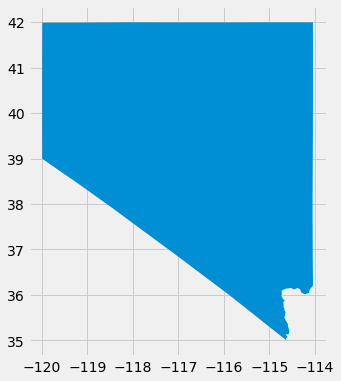

In [144]:
usa[usa.STATE_ABBR == 'NV'].plot()

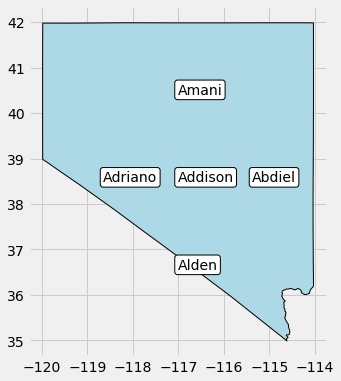

In [145]:
ax = usa[usa.STATE_ABBR == 'NV'].geometry.boundary.plot(fc='lightblue', color='black',edgecolor='grey',linewidth = 1)

bbox_props = dict(boxstyle="round,pad=0.2", fc="w", ec="k", lw=1)

NV_A_names = elon_plot_TX_NV_data_rarest[(elon_plot_TX_NV_data_rarest['state'] == 'NV') & (elon_plot_TX_NV_data_rarest['first_letter'] == 'A')]["name"].astype(str)
NV_A_names
coordinates = [[0.75, 0.5], [0.5, 0.5], [0.25, 0.5], [0.5, 0.25], [0.5, 0.75]]
for (x,y),c in zip(coordinates, NV_A_names):
  ax.annotate(c, xy=(-116, 39), xycoords='data', xytext=(x,y), textcoords='axes fraction', bbox=bbox_props)

#plt.axis('off')
plt.show()

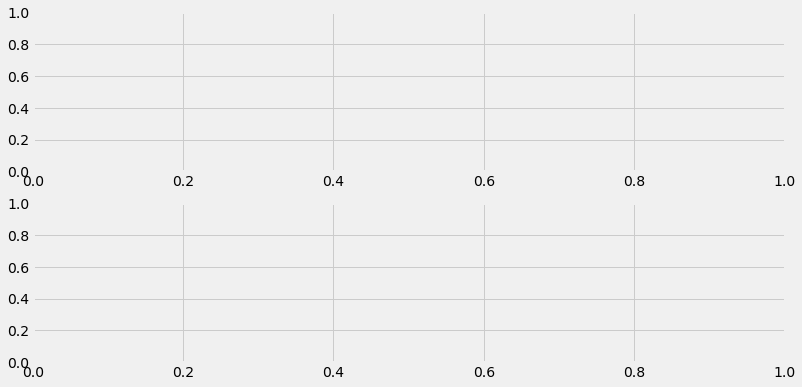

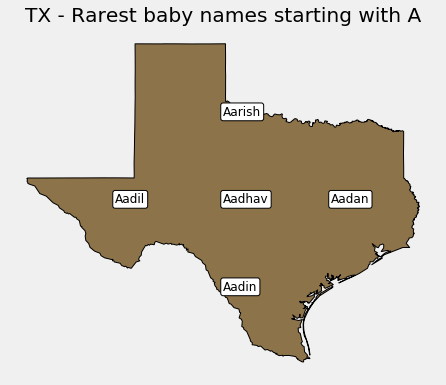

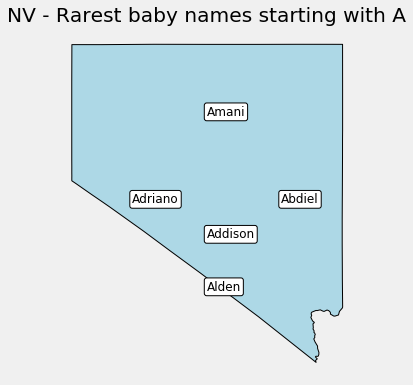

In [146]:
# Ensure plots are side by side
fig, axes = plt.subplots(nrows=2, ncols=1)

# Texas
axes[0] = usa[usa.STATE_ABBR == 'TX'].geometry.boundary.plot(fc='#8D734A', color='black',edgecolor='grey',linewidth = 1)

bbox_props = dict(boxstyle="round,pad=0.2", fc="w", ec="k", lw=1)

TX_A_names = elon_plot_TX_NV_data_rarest[(elon_plot_TX_NV_data_rarest['state'] == 'TX') & (elon_plot_TX_NV_data_rarest['first_letter'] == 'A')]["name"]
coordinates = [[0.75, 0.5], [0.5, 0.5], [0.25, 0.5], [0.5, 0.25], [0.5, 0.75]]
for (x,y),c in zip(coordinates, TX_A_names):
  axes[0].annotate(c, xy=(-100, 32), xycoords='data', xytext=(x,y), textcoords='axes fraction', bbox=bbox_props, fontsize=12)
plt.title('TX - Rarest baby names starting with A')
plt.axis('off')

# Nevada
axes[1] = usa[usa.STATE_ABBR == 'NV'].geometry.boundary.plot(fc='lightblue', color='black',edgecolor='grey',linewidth = 1)

bbox_props = dict(boxstyle="round,pad=0.2", fc="w", ec="k", lw=1)

NV_A_names = elon_plot_TX_NV_data_rarest[(elon_plot_TX_NV_data_rarest['state'] == 'NV') & (elon_plot_TX_NV_data_rarest['first_letter'] == 'A')]["name"]
#NV_A_names
coordinates = [[0.75, 0.5], [0.5, 0.4], [0.25, 0.5], [0.5, 0.25], [0.5, 0.75]]
for (x,y),c in zip(coordinates, NV_A_names):
  axes[1].annotate(c, xy=(-116, 39), xycoords='data', xytext=(x,y), textcoords='axes fraction', bbox=bbox_props,fontsize=12)
plt.title('NV - Rarest baby names starting with A')
plt.axis('off')
plt.show()

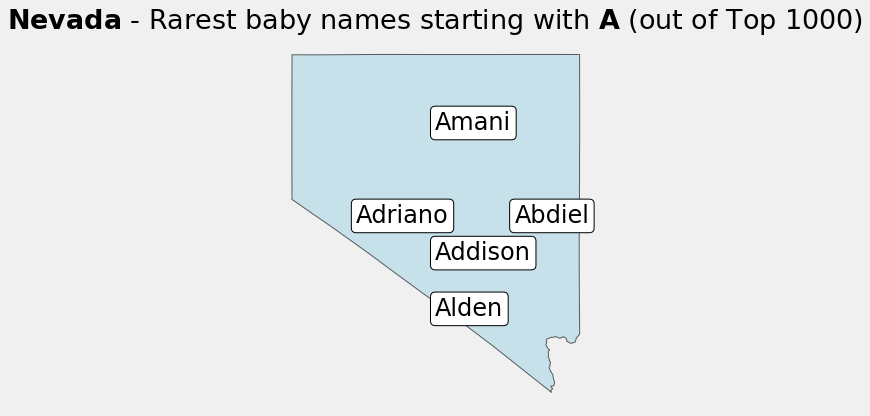

In [147]:
#plt.subplot(1, 2, 2)
# Nevada
ax2 = usa[usa.STATE_ABBR == 'NV'].geometry.boundary.plot(fc='lightblue', alpha=0.6, color='black', edgecolor='grey',linewidth = 1)

bbox_props = dict(boxstyle="round,pad=0.2", fc="w", ec="k", lw=1)

NV_A_names = elon_plot_TX_NV_data_rarest[(elon_plot_TX_NV_data_rarest['state'] == 'NV') & (elon_plot_TX_NV_data_rarest['first_letter'] == 'A')]["name"]

coordinates = [[0.75, 0.5], [0.5, 0.4], [0.25, 0.5], [0.5, 0.25], [0.5, 0.75]]
for (x,y),c in zip(coordinates, NV_A_names):
  ax2.annotate(c, xy=(-116, 39), xycoords='data', xytext=(x,y), textcoords='axes fraction', bbox=bbox_props,fontsize=24)
ax2.set_title(r"$\bf{" + "Nevada " + "}$" +  " - Rarest baby names starting with " + r"$\bf{" + " A " + "}$" + " (out of Top 1000)", fontdict={'size':27, 'weight':500}, pad=0)
plt.axis('off')
plt.tight_layout()
plt.savefig(Path.cwd() / "figs" / "plot5.png", dpi=200)

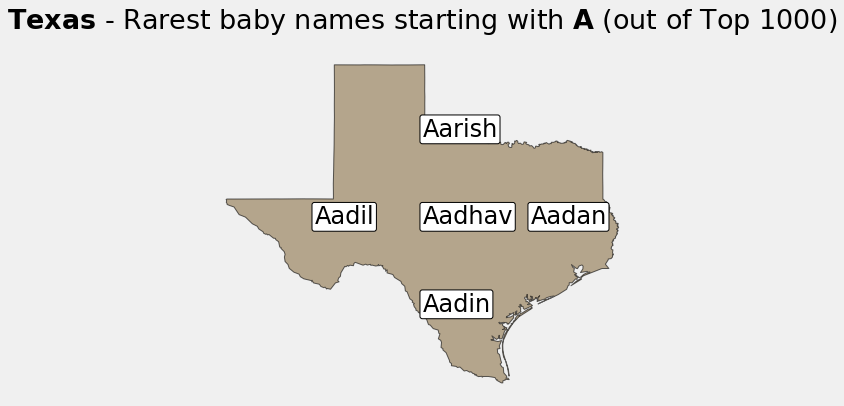

In [148]:
# Texas
ax1 = usa[usa.STATE_ABBR == 'TX'].geometry.boundary.plot(fc='#8D734A', alpha=0.6, color='black',edgecolor='grey',linewidth = 1)

bbox_props = dict(boxstyle="round,pad=0.1", fc="w", ec="k", lw=1)

TX_A_names = elon_plot_TX_NV_data_rarest[(elon_plot_TX_NV_data_rarest['state'] == 'TX') & (elon_plot_TX_NV_data_rarest['first_letter'] == 'A')]["name"]
coordinates = [[0.75, 0.5], [0.5, 0.5], [0.25, 0.5], [0.5, 0.25], [0.5, 0.75]]
for (x,y),c in zip(coordinates, TX_A_names):
  ax1.annotate(c, xy=(-100, 32), xycoords='data', xytext=(x,y), textcoords='axes fraction', bbox=bbox_props, fontsize=24)
ax1.set_title(r"$\bf{" + "Texas " + "}$" +  " - Rarest baby names starting with " + r"$\bf{" + " A " + "}$" + " (out of Top 1000)", fontdict={'size':27, 'weight':500}, pad=20)
plt.axis('off')
plt.savefig(Path.cwd() / "figs" / "plot6.png", dpi=200)

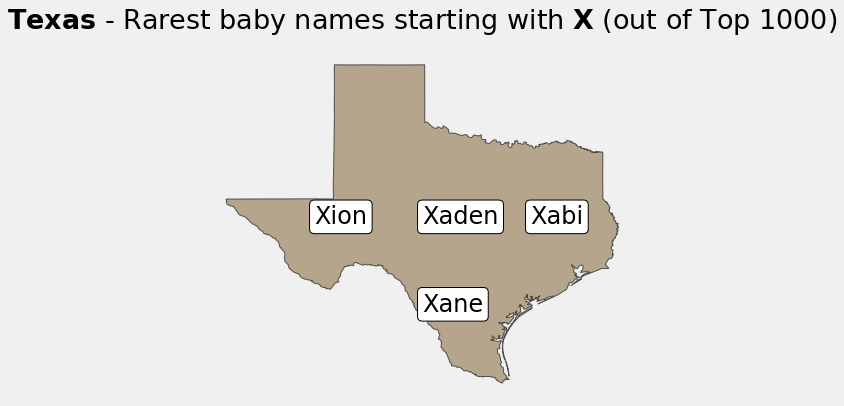

In [149]:
# Create two subplots sharing y axis
#fig, (ax1, ax2) = plt.subplots(1, 2)

# Texas
ax1 = usa[usa.STATE_ABBR == 'TX'].geometry.boundary.plot(fc='#8D734A', alpha=0.6, color='black',edgecolor='grey',linewidth = 1)

bbox_props = dict(boxstyle="round,pad=0.2", fc="w", ec="k", lw=1)

TX_X_names = elon_plot_TX_NV_data_rarest[(elon_plot_TX_NV_data_rarest['state'] == 'TX') & (elon_plot_TX_NV_data_rarest['first_letter'] == 'X')]["name"]
coordinates = [[0.75, 0.5], [0.5, 0.5], [0.25, 0.5], [0.5, 0.25]] # only 4 names with X
for (x,y),c in zip(coordinates, TX_X_names):
  ax1.annotate(c, xy=(-100, 32), xycoords='data', xytext=(x,y), textcoords='axes fraction', bbox=bbox_props, fontsize=24)
ax1.set_title(r"$\bf{" + "Texas " + "}$" +  " - Rarest baby names starting with " + r"$\bf{" + " X " + "}$" + " (out of Top 1000)", fontdict={'size':27, 'weight':500}, pad=20)
plt.axis('off')
plt.savefig(Path.cwd() / "figs" / "plot4.png", dpi=200)
#plt.show()

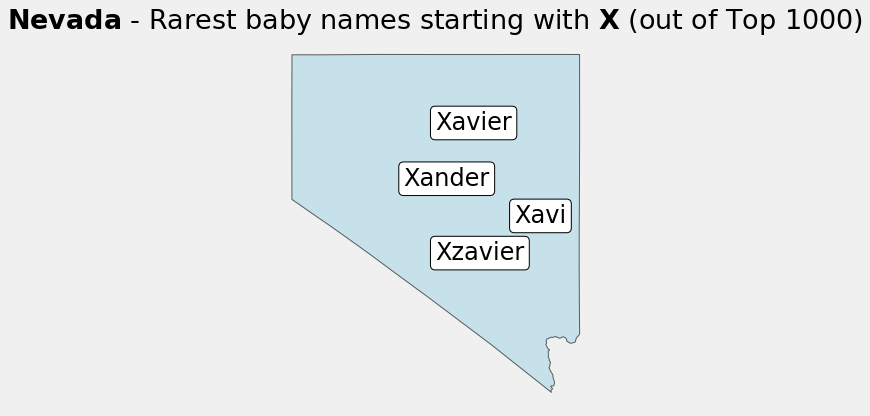

In [150]:

#plt.subplot(1, 2, 2)
# Nevada
ax2 = usa[usa.STATE_ABBR == 'NV'].geometry.boundary.plot(fc='lightblue', alpha=0.6, color='black', edgecolor='grey',linewidth = 1)

bbox_props = dict(boxstyle="round,pad=0.2", fc="w", ec="k", lw=1)

NV_X_names = elon_plot_TX_NV_data_rarest[(elon_plot_TX_NV_data_rarest['state'] == 'NV') & (elon_plot_TX_NV_data_rarest['first_letter'] == 'X')]["name"]

coordinates = [[0.75, 0.5], [0.5, 0.4], [.4, 0.6], [0.5, 0.75], [0.5, 0.75]] 
for (x,y),c in zip(coordinates, NV_X_names):
  ax2.annotate(c, xy=(-116, 39), xycoords='data', xytext=(x,y), textcoords='axes fraction', bbox=bbox_props,fontsize=24)
ax2.set_title(r"$\bf{" + "Nevada " + "}$" +  " - Rarest baby names starting with " + r"$\bf{" + " X " + "}$" + " (out of Top 1000)", fontdict={'size':27, 'weight':500}, pad=0)
plt.axis('off')
plt.tight_layout()
plt.savefig(Path.cwd() / "figs" / "plot3.png", dpi=200)


### Michael Jordan - Do you want to Be Like Mike or just Be (named liked) Mike?

* Moving on from one billionaire in silicon valley to another in the sports world
* https://www.businessinsider.com/how-michael-jordan-spends-his-money-2015-3#jordan-is-the-worlds-first-athlete-billionaire-1)
* One more, current events, you may be watching the last dance with Michael Jordan. How popular did Mike>
* How many babies were born like Mike?

* https://en.wikipedia.org/wiki/Dimitri_Vegas_%26_Like_Mike #musician 
* https://www.youtube.com/watch?v=b0AGiq9j_Ak # Be Like Mike original commericial

### Was there a boom in baby's named after Mike?

In [151]:
Mike = baby_names[(baby_names['year'] >= 1980) & (baby_names['year'] <= 2000) & (baby_names['sex'] == 'M') & (baby_names['name'].isin(['Mike']))]
Mike.sort_values('year')

,name,sex,babies,year,first_letter
12559,Mike,M,408,1980,M
12586,Mike,M,409,1981,M
12798,Mike,M,322,1982,M
12549,Mike,M,309,1983,M
12665,Mike,M,291,1984,M
12958,Mike,M,351,1985,M
13316,Mike,M,322,1986,M
13765,Mike,M,309,1987,M
14344,Mike,M,381,1988,M
15021,Mike,M,401,1989,M


* How about Jordan?

In [152]:
Jordan = baby_names[(baby_names['year'] >= 1980) & (baby_names['year'] <= 2020) & (baby_names['sex'].isin(['F','M'])) & (baby_names['name'].isin(['Jordan']))]
Jordan.groupby(['year','name'])['babies'].sum()

year  name  
1980  Jordan     1993
1981  Jordan     3407
1982  Jordan     4005
1983  Jordan     4514
1984  Jordan     5133
1985  Jordan     6434
1986  Jordan     9385
1987  Jordan    10308
1988  Jordan    10617
1989  Jordan    15154
1990  Jordan    22090
1991  Jordan    21573
1992  Jordan    19395
1993  Jordan    20578
1994  Jordan    20416
1995  Jordan    20047
1996  Jordan    20149
1997  Jordan    21926
1998  Jordan    21520
1999  Jordan    18781
2000  Jordan    17975
2001  Jordan    16616
2002  Jordan    17302
2003  Jordan    15979
2004  Jordan    14001
2005  Jordan    13089
2006  Jordan    13468
2007  Jordan    13378
2008  Jordan    11739
2009  Jordan    10747
2010  Jordan     9964
2011  Jordan     9705
2012  Jordan     9230
2013  Jordan     8434
2014  Jordan     8181
2015  Jordan     7519
2016  Jordan     6752
2017  Jordan     6018
2018  Jordan     5474
Name: babies, dtype: int64

In [153]:
Michael = baby_names[(baby_names['year'] >= 1980) & (baby_names['year'] <= 2000) & (baby_names['sex'] == 'M') & (baby_names['name'].isin(['Michael']))]
Michael.sort_values('year')

,name,sex,babies,year,first_letter
12158,Michael,M,68696,1980,M
12184,Michael,M,68763,1981,M
12328,Michael,M,68235,1982,M
12068,Michael,M,68000,1983,M
12172,Michael,M,67741,1984,M
12500,Michael,M,64912,1985,M
12830,Michael,M,64208,1986,M
13255,Michael,M,63655,1987,M
13877,Michael,M,64143,1988,M
14546,Michael,M,65389,1989,M


In [154]:
Mike_bystate = baby_namesbystate[(baby_namesbystate['year'] >= 1980) & (baby_namesbystate['year'] <= 2000) & (baby_namesbystate['sex'] == 'M') & (baby_namesbystate['name'].isin(['Michael'])) & (baby_namesbystate['state'].isin(['IL','NC']))]
Mike_bystate.sort_values(['state', 'year'])

,state,sex,year,name,babies,first_letter
176847,IL,M,1980,Michael,3756,M
177876,IL,M,1981,Michael,3524,M
178883,IL,M,1982,Michael,3546,M
179879,IL,M,1983,Michael,3583,M
180834,IL,M,1984,Michael,3606,M
181811,IL,M,1985,Michael,3369,M
182810,IL,M,1986,Michael,3249,M
183802,IL,M,1987,Michael,3376,M
184825,IL,M,1988,Michael,3444,M
185887,IL,M,1989,Michael,3580,M


# Shaq

In [155]:
How about one of Mike's opponents (who happens to share the honor of being a rookie All-Star starter and also a a "People also search for" recommendation on Google) with a more unique name? 

SyntaxError: invalid syntax (<ipython-input-155-91c6e42063d8>, line 1)

In [156]:
Shaq = baby_names[(baby_names['year'] >= 1980) & (baby_names['year'] <= 2020) & (baby_names['sex'] == 'M') & (baby_names['name'].isin(['Shaquille']))]
Shaq.sort_values('year')

,name,sex,babies,year,first_letter
18538,Shaquille,M,14,1989,S
16357,Shaquille,M,92,1990,S
16180,Shaquille,M,198,1991,S
16035,Shaquille,M,524,1992,S
15976,Shaquille,M,1784,1993,S
15985,Shaquille,M,1271,1994,S
16207,Shaquille,M,494,1995,S
16552,Shaquille,M,250,1996,S
17383,Shaquille,M,96,1997,S
18194,Shaquille,M,66,1998,S


In [157]:
# looks at breakdown by state

* Looks like the lakers 3 peat in 2000 didn't cause a Shaq baby boom like his rookie year.

In [158]:
# Shaq's rokie year was in 1993

* And last but not least, Shaq's late teammate, Kobe Bryant - looks like his baby name popularity peaked during the lakers 2nd championship run in 2001

In [159]:
Kobe = baby_names[(baby_names['year'] >= 1980) & (baby_names['sex'] == 'M') & (baby_names['name'].isin(['Kobe']))]
Kobe.sort_values('year')

,name,sex,babies,year,first_letter
23180,Kobe,M,5,1989,K
21948,Kobe,M,9,1995,K
17160,Kobe,M,87,1996,K
16710,Kobe,M,350,1997,K
16860,Kobe,M,1104,1998,K
17264,Kobe,M,860,1999,K
17891,Kobe,M,1432,2000,K
18193,Kobe,M,1552,2001,K
18324,Kobe,M,1392,2002,K
18694,Kobe,M,1213,2003,K


In [160]:
Shaq = baby_names[(baby_names['year'] >= 1980) & (baby_names['year'] <= 2020) & (baby_names['sex'] == 'M') & (baby_names['name'].isin(['Shaq']))]
Shaq.sort_values('year')

,name,sex,babies,year,first_letter


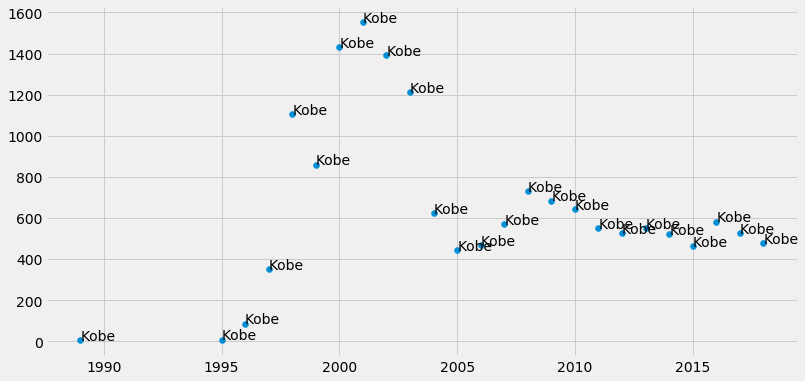

In [161]:
x = Kobe['year']

y =  Kobe['babies']
n = Kobe['name']
fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
     ax.annotate(txt, (x.iloc[i], y.iloc[i]))
#plt.show()

In [244]:
players = baby_names[(baby_names['year'] >= 1980) & (baby_names['year'] <= 2020) & (baby_names['sex'] == 'M') & (baby_names['name'].isin(['Shaquille','Kobe','Michael','Mike', 'Shaq', 'Lebron', 'Jordan']))]
players.sort_values('year')

,name,sex,babies,year,first_letter
12158,Michael,M,68696,1980,M
12317,Jordan,M,1620,1980,J
12559,Mike,M,408,1980,M
18997,Lebron,M,5,1980,L
12285,Jordan,M,2923,1981,J
...,...,...,...,...,...
18109,Jordan,M,4646,2018,J
18601,Kobe,M,478,2018,K
19152,Mike,M,171,2018,M
20428,Shaquille,M,55,2018,S


* Remember the old adage correlation isn't causation

### Line Chart - https://www.dataquest.io/blog/making-538-plots/

* Need to get data in correct format/shape first
* Also get YOY change instead of just absolute numbers

In [245]:
players.head()

,name,sex,babies,year,first_letter
17655,Michael,M,32037,2000,M
17689,Jordan,M,12168,2000,J
17891,Kobe,M,1432,2000,K
18254,Mike,M,329,2000,M
19544,Shaquille,M,56,2000,S


In [246]:
players_pivoted = players.pivot(index='year', columns='name', values='babies').reset_index()
players_pivoted

name,year,Jordan,Kobe,Lebron,Michael,Mike,Shaquille
0,1980,1620.0,NaN,5.0,68696.0,408.0,NaN
1,1981,2923.0,NaN,7.0,68763.0,409.0,NaN
2,1982,3535.0,NaN,NaN,68235.0,322.0,NaN
3,1983,4015.0,NaN,9.0,68000.0,309.0,NaN
4,1984,4539.0,NaN,5.0,67741.0,291.0,NaN
5,1985,5459.0,NaN,11.0,64912.0,351.0,NaN
6,1986,7301.0,NaN,5.0,64208.0,322.0,NaN
7,1987,8408.0,NaN,7.0,63655.0,309.0,NaN
8,1988,8488.0,NaN,NaN,64143.0,381.0,NaN
9,1989,10874.0,5.0,NaN,65389.0,401.0,14.0


In [247]:
df_pct_change = players_pivoted.pct_change().add_suffix('_pct_change')
df_pct_change.drop(columns=['year_pct_change'], inplace = True) 
df_pct_change[df_pct_change.select_dtypes(include=['number']).columns] *= 100
df_pct_change = df_pct_change.round(2)
df_pct_change

name,Jordan_pct_change,Kobe_pct_change,Lebron_pct_change,Michael_pct_change,Mike_pct_change,Shaquille_pct_change
0,NaN,NaN,NaN,NaN,NaN,NaN
1,80.43,NaN,40.00,0.10,0.25,NaN
2,20.94,NaN,0.00,-0.77,-21.27,NaN
3,13.58,NaN,28.57,-0.34,-4.04,NaN
4,13.05,NaN,-44.44,-0.38,-5.83,NaN
5,20.27,NaN,120.00,-4.18,20.62,NaN
6,33.74,NaN,-54.55,-1.08,-8.26,NaN
7,15.16,NaN,40.00,-0.86,-4.04,NaN
8,0.95,NaN,0.00,0.77,23.30,NaN
9,28.11,NaN,0.00,1.94,5.25,NaN


### Combine dataframes together

In [248]:
players_final = pd.merge(players_pivoted, df_pct_change, left_index=True, right_index=True)
#players_final.set_index(['year'], inplace = True)
players_final.head() #name column is not correct but we don't need it

name,year,Jordan,Kobe,Lebron,Michael,Mike,Shaquille,Jordan_pct_change,Kobe_pct_change,Lebron_pct_change,Michael_pct_change,Mike_pct_change,Shaquille_pct_change
0,1980,1620.0,NaN,5.0,68696.0,408.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981,2923.0,NaN,7.0,68763.0,409.0,NaN,80.43,NaN,40.00,0.10,0.25,NaN
2,1982,3535.0,NaN,NaN,68235.0,322.0,NaN,20.94,NaN,0.00,-0.77,-21.27,NaN
3,1983,4015.0,NaN,9.0,68000.0,309.0,NaN,13.58,NaN,28.57,-0.34,-4.04,NaN
4,1984,4539.0,NaN,5.0,67741.0,291.0,NaN,13.05,NaN,-44.44,-0.38,-5.83,NaN


In [249]:
Y_COLUMNS = ['Mike','Shaquille','Kobe','Michael']
Y_COLUMNS = ['Mike','Shaquille','Kobe', 'Lebron']

Type: <class 'matplotlib.axes._subplots.AxesSubplot'>


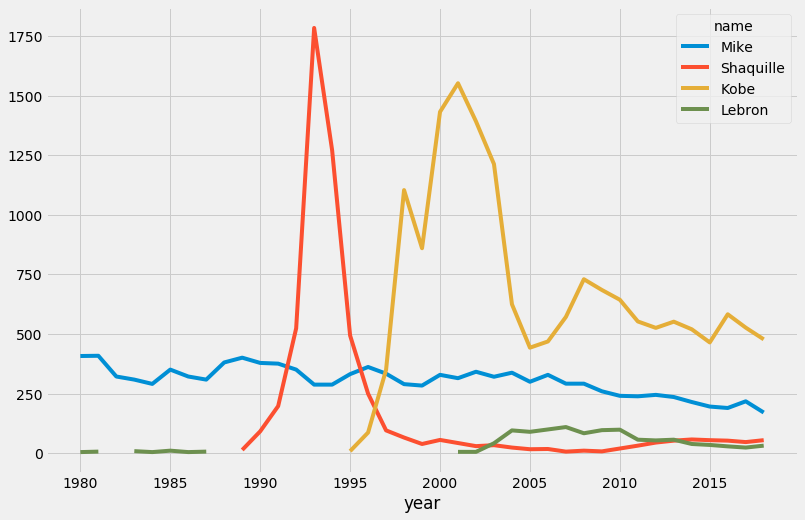

In [250]:
players_graph = players_final.plot(x = 'year', y = Y_COLUMNS, figsize = (12,8))
print('Type:', type(players_graph))

In [251]:
import matplotlib.style as style
style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

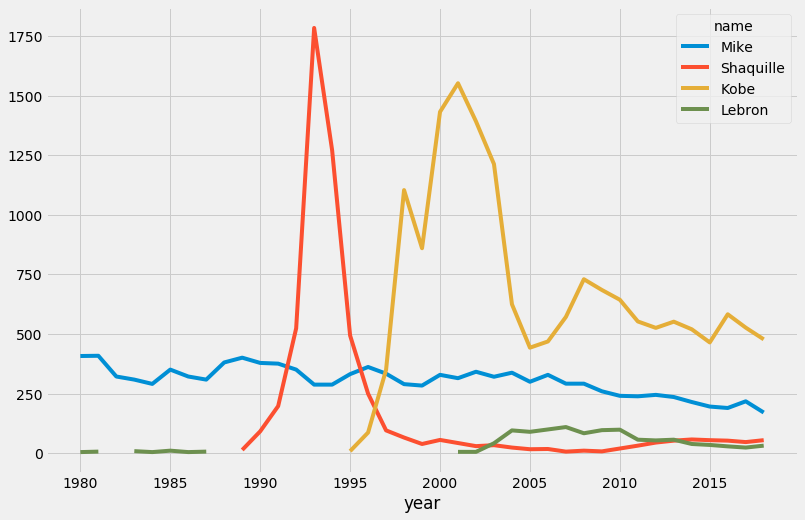

In [252]:
style.use('fivethirtyeight')
players_final.plot(x = 'year', y = Y_COLUMNS, figsize = (12,8))

In [253]:
plt.rcParams["figure.figsize"] = (12, 6)

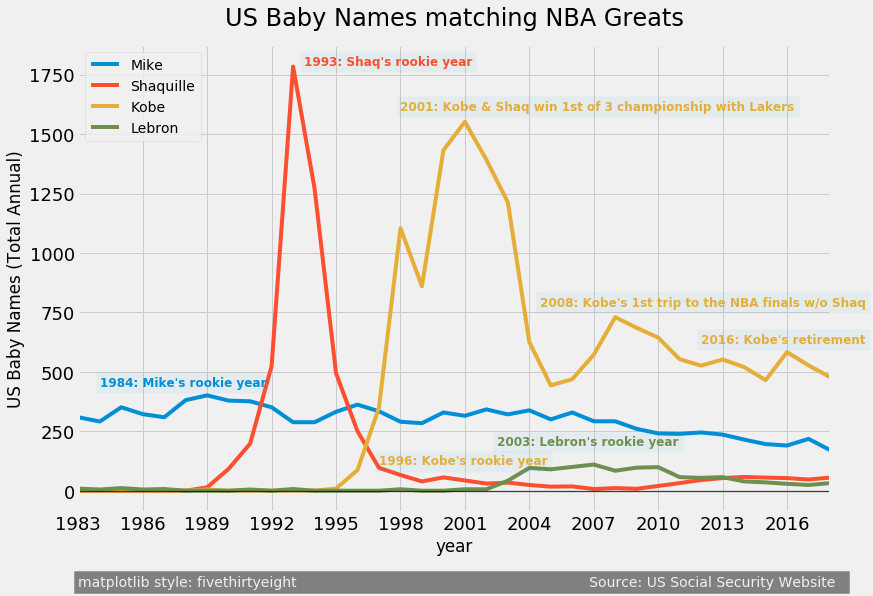

In [295]:
# Colors matching current pallette
Y_COLUMNS = ['Mike','Shaquille','Kobe', 'Lebron']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fte_graph = players_final.fillna(0).plot(x = 'year', y = Y_COLUMNS, figsize = (12,8), legend = True)

fte_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)
fte_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

fte_graph.set_xlim(left = 1983, right = 2018)
fte_graph.text(x = 1983, y = -400,
    s = 'matplotlib style: fivethirtyeight                                                                 Source: US Social Security Website  ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey')

# set ticker for each 3 years
x_ticks = np.arange(1983, 2018, 3)
plt.xticks(x_ticks)

# Add colored labels
fte_graph.text(x = 1984, y = 440, s = "1984: Mike's rookie year", color = colors[0], weight = 'bold', rotation = 0, backgroundcolor = '#f0f0f0', fontsize = 12).set_bbox(dict(alpha=0.05))
fte_graph.text(x = 1993.5, y = 1790, s = "1993: Shaq's rookie year", color = colors[1], weight = 'bold', rotation = 0, backgroundcolor = '#f0f0f0', fontsize = 12).set_bbox(dict(alpha=0.05))
fte_graph.text(x = 1997, y = 110, s = "1996: Kobe's rookie year", color = colors[2], weight = 'bold', rotation = 0, backgroundcolor = '#f0f0f0', fontsize = 12).set_bbox(dict(alpha=0.05))
fte_graph.text(x = 1998, y = 1600, s = "2001: Kobe & Shaq win 1st of 3 championship with Lakers", color = colors[2], weight = 'bold', rotation = 0, backgroundcolor = '#f0f0f0', fontsize = 12).set_bbox(dict(alpha=0.05))
fte_graph.text(x = 2002.5, y = 190, s = "2003: Lebron's rookie year", color = colors[3], weight = 'bold',
backgroundcolor = '#f0f0f0', fontsize = 12).set_bbox(dict(alpha=0.05))
fte_graph.text(x = 2004.5, y = 775, s = "2008: Kobe's 1st trip to the NBA finals w/o Shaq", color = colors[2], weight = 'bold', rotation = 0, backgroundcolor = '#f0f0f0', fontsize = 12).set_bbox(dict(alpha=0.05))
fte_graph.text(x = 2012, y = 620, s = "2016: Kobe's retirement", color = colors[2], weight = 'bold', rotation = 0, backgroundcolor = '#f0f0f0', fontsize = 12).set_bbox(dict(alpha=0.05))
# fte_graph.text(x = 1976, y = 25, s = 'Physical Sciences', color = colors[5], weight = 'bold', rotation = 27,
#               backgroundcolor = '#f0f0f0')
fte_graph.set_title("US Baby Names matching NBA Greats", fontdict={'size':24}, pad=20)
plt.ylabel('US Baby Names (Total Annual)')
plt.legend(loc='upper left')
# Add grey border
#plt.figure(linewidth=8, edgecolor='grey').savefig(Path.cwd() / "figs" / "plot7.png")
plt.savefig(Path.cwd() / "figs" / "plot7.png", dpi = 200)

In [173]:
# Look at 
# Mike (nickname)
# Michael (fullname)

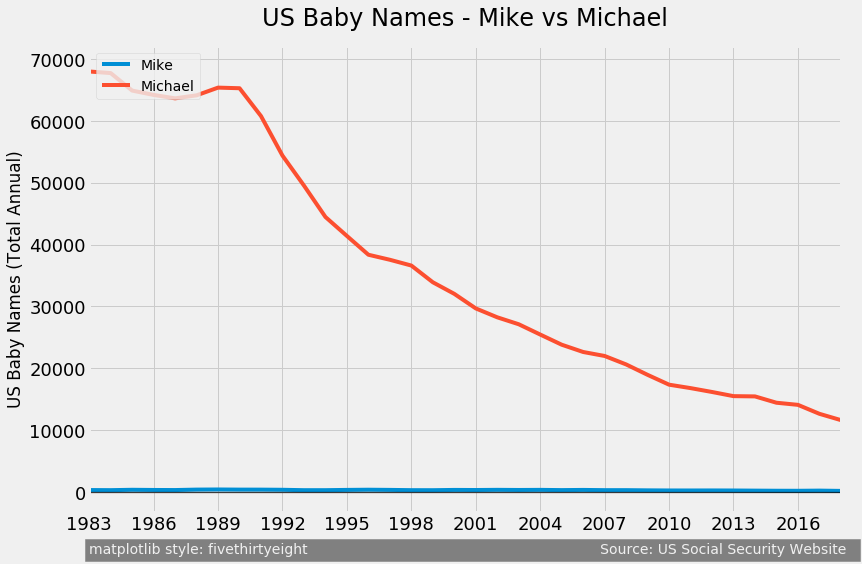

In [296]:
# Colors matching current pallette
Y_COLUMNS = ['Mike', 'Michael']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fte_graph = players_final.fillna(0).plot(x = 'year', y = Y_COLUMNS, figsize = (12,8), legend = True)

fte_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)
fte_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

fte_graph.set_xlim(left = 1983, right = 2018)
fte_graph.text(x = 1983, y = -10000,
    s = 'matplotlib style: fivethirtyeight                                                                 Source: US Social Security Website  ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey')

# set ticker for each 3 years
x_ticks = np.arange(1983, 2018, 3)
plt.xticks(x_ticks)

#               backgroundcolor = '#f0f0f0')
fte_graph.set_title("US Baby Names - Mike vs Michael", fontdict={'size':24}, pad=20)
plt.ylabel('US Baby Names (Total Annual)')
plt.legend(loc='upper left')
# Add grey border
#plt.figure(linewidth=8, edgecolor='grey').savefig(Path.cwd() / "figs" / "plot7.png")
plt.savefig(Path.cwd() / "figs" / "plot8.png", dpi = 200)

### Pandemic Names

* Finally, if you are lucky enough to be expecting a baby boy or girl, how about choosing a name that was popular doingin the last major pandemic?

In [174]:
spanish_flu_pandemic_decade = baby_names[(baby_names['year'] >= 1908) & (baby_names['year'] <= 1918)]
a = spanish_flu_pandemic_decade.groupby(['name','sex'])['babies'].sum().reset_index()
#a['babies'] = a.groupby(['sex'])['babies'].rank(method='dense', ascending=False) # Need to use rank for plotting purposes
top_5_spanish_flu_decade = a.groupby(['sex'])['babies'].nlargest(5).reset_index().set_index('level_1').join(a['name'])
top_5_spanish_flu_decade
top_5_spanish_flu_decade['babies'].max()

341723

In [175]:
current_decade = baby_names[(baby_names['year'] >= 2008) & (baby_names['year'] <= 2018)]
b = current_decade.groupby(['name','sex'])['babies'].sum().reset_index()
#b['babies'] = b.groupby(['sex'])['babies'].rank(method='dense', ascending=False) # Need to use rank for plotting purposes
top_5_current_decade = b.groupby(['sex'])['babies'].nlargest(5).reset_index().set_index('level_1').join(b['name'])
top_5_current_decade

,sex,babies,name
level_1,,,
46250,F,200097,Olivia
7196,F,173891,Ava
23944,F,152412,Isabella
18636,F,141935,Emily
617,F,138725,Abigail
45557,M,196691,Noah
24683,M,195789,Jacob
59438,M,182202,William
19354,M,177575,Ethan


In [176]:
# Need to ensure all top 5 male/females names are represented in both decades

In [177]:
names_of_interest = top_5_current_decade[['name','sex']].append(top_5_spanish_flu_decade[['name','sex']])\
.groupby(['name','sex']).size().reset_index().rename(columns={0:'count'}) #union the data and then find unique values
names_of_interest
#len(names_of_interest)

,name,sex,count
0,Abigail,F,1
1,Ava,F,1
2,Dorothy,F,1
3,Emily,F,1
4,Ethan,M,1
5,Helen,F,1
6,Isabella,F,1
7,Jacob,M,1
8,James,M,1
9,John,M,1


In [178]:
old = a.merge(names_of_interest[['name','sex']], how = 'inner')\
.rename(columns={'babies':'1908-1918'}) ##.rename(columns={'babies':'total_baby_names_2008_2018'})
old['1908-1918_rank'] = old['1908-1918'].rank(method='dense', ascending=False) # Need to use rank for plotting purposes
old

,name,sex,1908-1918,1908-1918_rank
0,Abigail,F,264,18.0
1,Ava,F,1349,17.0
2,Dorothy,F,187698,6.0
3,Emily,F,16244,12.0
4,Ethan,M,167,19.0
5,Helen,F,232138,4.0
6,Isabella,F,1981,15.0
7,Jacob,M,8099,13.0
8,James,M,247292,3.0
9,John,M,341723,1.0


In [179]:
new = b.merge(names_of_interest[['name','sex']], how = 'inner')\
.rename(columns={'babies':'2008-2018'}) #.rename(columns={'babies':'total_baby_names_2008_2018'})})
new['2008-2018_rank'] = new['2008-2018'].rank(method='dense', ascending=False) # Need to use rank for plotting purposes
new

,name,sex,2008-2018,2008-2018_rank
0,Abigail,F,138725,11.0
1,Ava,F,173891,6.0
2,Dorothy,F,3859,18.0
3,Emily,F,141935,10.0
4,Ethan,M,177575,5.0
5,Helen,F,8542,17.0
6,Isabella,F,152412,9.0
7,Jacob,M,195789,3.0
8,James,M,155446,8.0
9,John,M,119067,13.0


In [180]:
slopechart_data = pd.merge(new, old, how='inner')
slopechart_data.head()

,name,sex,2008-2018,2008-2018_rank,1908-1918,1908-1918_rank
0,Abigail,F,138725,11.0,264,18.0
1,Ava,F,173891,6.0,1349,17.0
2,Dorothy,F,3859,18.0,187698,6.0
3,Emily,F,141935,10.0,16244,12.0
4,Ethan,M,177575,5.0,167,19.0


In [282]:
#based off this example https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#18.-Slope-Chart
df = slopechart_data
left_label = [str(c) + ', '+ str(round(y)) for c, y in zip(df.name, df['1908-1918_rank'])]
right_label = [str(c) + ', '+ str(round(y)) for c, y in zip(df.name, df['2008-2018_rank'])]
klass = [ '#e75480' if sex == 'F' else '#003366' for sex in df['sex'].to_list()] #blue and pink 
klass

['#e75480',
 '#e75480',
 '#e75480',
 '#e75480',
 '#003366',
 '#e75480',
 '#e75480',
 '#003366',
 '#003366',
 '#003366',
 '#003366',
 '#e75480',
 '#003366',
 '#e75480',
 '#003366',
 '#e75480',
 '#003366',
 '#e75480',
 '#003366']

In [283]:

# draw line
# https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='green' if p1[1]-p2[1] > 0 else 'red', marker='o', alpha= 0.25, markersize=6)
    ax.add_line(l)
    return l


In [284]:
?ax.text

Signature: ax.text(x, y, s, fontdict=None, withdash=<deprecated parameter>, **kwargs)
Docstring:
Add text to the axes.

Add the text *s* to the axes at location *x*, *y* in data coordinates.

Parameters
----------
x, y : scalars
    The position to place the text. By default, this is in data
    coordinates. The coordinate system can be changed using the
    *transform* parameter.

s : str
    The text.

fontdict : dictionary, optional, default: None
    A dictionary to override the default text properties. If fontdict
    is None, the defaults are determined by your rc parameters.

withdash : boolean, optional, default: False
    Creates a `~matplotlib.text.TextWithDash` instance instead of a
    `~matplotlib.text.Text` instance.

Returns
-------
text : `.Text`
    The created `.Text` instance.

Other Parameters
----------------
**kwargs : `~matplotlib.text.Text` properties.
    Other miscellaneous text parameters.

Examples
--------
Individual keyword arguments can be used to overrid

In [297]:
style.use('classic') #shift back from 538 theme to default

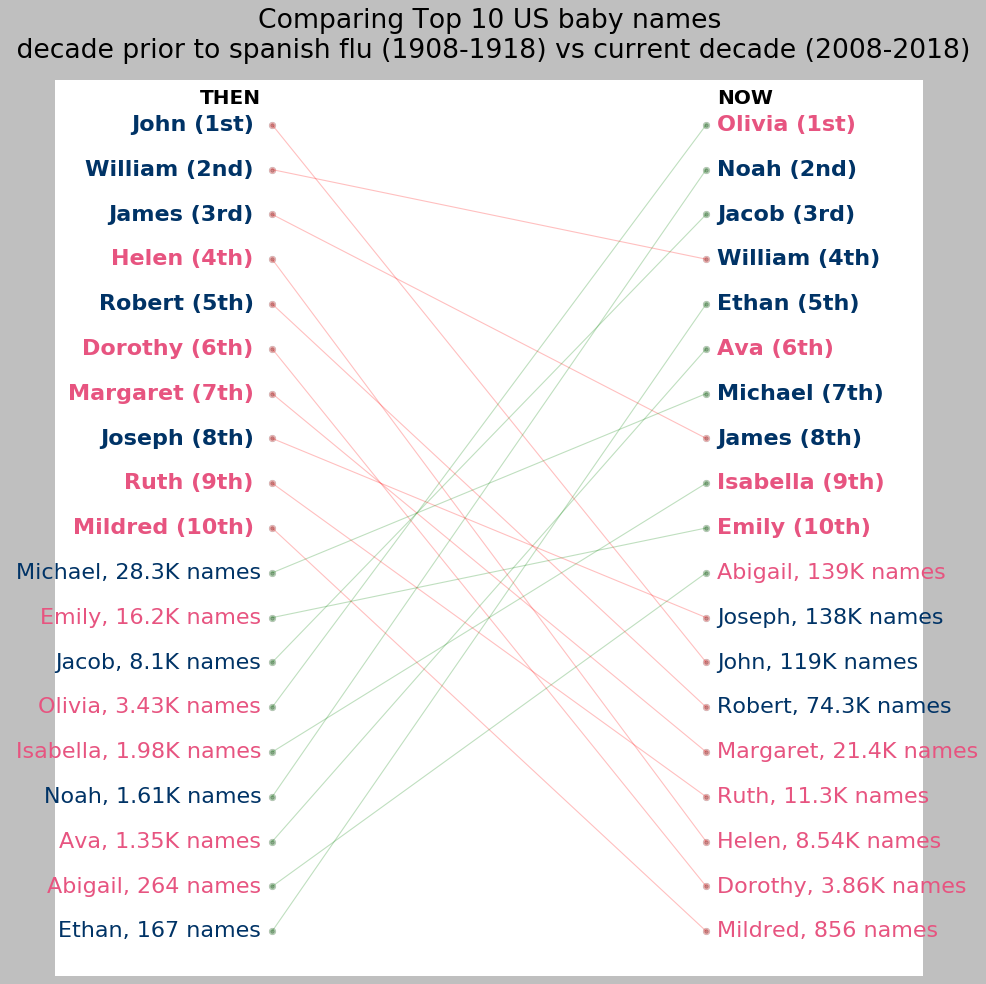

In [299]:
fig, ax = plt.subplots(1,1,figsize=(14,14), dpi= 80)

# Vertical Lines
ax.vlines(x=1, ymin=50, ymax=1300, color='black', alpha=0.7, linewidth=0.25, linestyles='dotted')
ax.vlines(x=3, ymin=50, ymax=1300, color='black', alpha=0.7, linewidth=0.25, linestyles='dotted')

# Points
ax.scatter(y=df['1908-1918_rank'], x=np.repeat(1, df.shape[0]), s=10, color='black', alpha=0.25)
ax.scatter(y=df['2008-2018_rank'], x=np.repeat(3, df.shape[0]), s=10, color='black', alpha=0.25)

# Helper formatting functions

#https://stackoverflow.com/questions/9647202/ordinal-numbers-replacement
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4])

#https://stackoverflow.com/questions/579310/formatting-long-numbers-as-strings-in-python
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

# Line Segments and Annotation
for p1, p2, name, sex, p1_value, p2_value in zip(df['1908-1918_rank'], df['2008-2018_rank'], df['name'], klass, df['1908-1918'], df['2008-2018']):
    newline([1,p1], [3,p2])
    ax.text(1-0.05, p1, (name + ' (' + ordinal(round(p1)) + ') ') if p1 <= 10 else (name + ', ' + human_format(p1_value) + " names") , horizontalalignment='right', verticalalignment='center', fontdict={'size':20}, color=sex, weight='heavy' if p1 <= 10 else 'normal', alpha = 1)
    ax.text(3+0.05, p2, (name + ' (' + ordinal(round(p2)) + ') ') if p2 <= 10 else (name + ', ' + human_format(p2_value) + " names") , horizontalalignment='left', verticalalignment='center', fontdict={'size':20}, color=sex,  weight='heavy' if p2 <= 10 else 'normal', alpha = 1)

# 'Before' and 'After' Annotations
ax.text(1-0.05, 0.4, 'THEN', horizontalalignment='right', verticalalignment='center', fontdict={'size':18, 'weight':550})
ax.text(3+0.05, 0.4, 'NOW', horizontalalignment='left', verticalalignment='center', fontdict={'size':18, 'weight':550})

# Decoration
ax.set_title("Comparing Top 10 US baby names\n decade prior to spanish flu (1908-1918) vs current decade (2008-2018)", fontdict={'size':24}, pad=20)
ax.set(xlim=(0,4), ylim=(0,20), ylabel='') #caveat I know this is not precisely a decade 
ax.set_xticks([1,3])
ax.set_xticklabels(["(1908-1918)", "(2008-2018)"], fontsize=15)
#plt.yticks(np.arange(5, 20, 1), fontsize=12)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)
plt.gca().invert_yaxis()
# Hide some stuff as per #https://stackoverflow.com/questions/2176424/hiding-axis-text-in-matplotlib-plots
ax.axes.get_yaxis().set_visible(False)
ax.set_xticks([])
plt.savefig(Path.cwd() / "figs" / "plot9.png", dpi = 200)